In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
import regex as re
import json
import os
import math
import random
from datetime import datetime, timedelta
import pickle
historical_data_url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
MAP_KEY = "85ad147fd1890d06e0e2db5bb9d95b57"
da_url = 'https://firms.modaps.eosdis.nasa.gov/api/country/csv/' + MAP_KEY + '/MODIS_NRT/USA/10/2025-1-19'

In [141]:
def param_generator(lat, long, year, month, day):
    base_date = datetime(year, month, day)

    end_date = base_date - timedelta(days=10)

    start_date = base_date - timedelta(days=50)

    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    return {
        "latitude": lat,
        "longitude": long,
        "daily": ["temperature_2m_max", "temperature_2m_min",
                  "precipitation_sum", "rain_sum", "showers_sum",
                  "snowfall_sum", "wind_speed_10m_max", "wind_gusts_10m_max",
                  "et0_fao_evapotranspiration"],
        "start_date": start_date_str,
        "end_date": end_date_str
    }

In [142]:
def clean_weather(url, params):
  data = requests.get(url, params);
  clean = re.split(r'(?<=\}),(?=\{)', data.text)
  cleaned_df = pd.DataFrame()
  for coordinate_json in clean:
      extract_cords = re.search(r'{"latitude":[\d\.-]+,"longitude":[\d\.-]+,',
                                coordinate_json)
      extract_output = re.search(r'"daily":{(.*})}', coordinate_json)
      cleaned_df = pd.concat([cleaned_df, pd.read_json(
          StringIO(extract_cords.group() + extract_output.group(1))
          )
      ])
  divide_time = cleaned_df['time'].str.split(r'\-')
  cleaned_df['year'] = divide_time.str[0]
  cleaned_df['month'] = divide_time.str[1]
  cleaned_df['day'] = divide_time.str[2]
  cleaned_df.drop(columns=['time'], inplace=True)
  new_column_order = ['latitude', 'longitude', 'year', 'month', 'day',
                      'temperature_2m_max', 'temperature_2m_min',
                      'precipitation_sum', 'rain_sum', 'showers_sum',
                      'snowfall_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max',
                      'et0_fao_evapotranspiration']
  return cleaned_df[new_column_order]

In [143]:
#@title to JSON func
def to_fire_data(df):

  json_data = df.to_dict(orient='records')

  if os.path.exists("/content/negative_data.json") and os.path.getsize("/content/negative_data.json") > 0:
    with open("/content/negative_data.json", "r") as f:
      try:
        existing_data = json.load(f)
      except json.JSONDecodeError:
        existing_data = []
  else:
    existing_data = []

  existing_data.extend(json_data)

  with open("/content/negative_data.json", "w") as f:
    json.dump(existing_data, f)

  return


In [144]:
def get_data_fire():
  # generate random year month date between the function of MODIS_SP satellite
  rand_year = random.randint(2017, 2023)
  rand_month = random.randint(1, 12)
  rand_day = random.randint(1, 30)
  #get fire data
  nasa_url = 'https://firms.modaps.eosdis.nasa.gov/api/country/csv/' + MAP_KEY + '/MODIS_SP/USA/1/' + str(rand_year) + '-' + str(rand_month) + '-' + str(rand_day)
  df = pd.read_csv(nasa_url)
  df['latitude'] = np.round(df['latitude'], 2)
  df['longitude']  = np.round(df['longitude'], 2)
  df = (
      df[df['confidence'] >= 80]
      .set_index(['latitude', 'longitude'])
      .index.unique()
      )
  fire_lat = [i[0] for i in df]
  fire_long = [i[1] for i in df]
  #get weather data
  weather_data = clean_weather(historical_data_url, param_generator(fire_lat, fire_long, rand_year, rand_month, rand_day))
  weather_data['fire'] = 1
  #write to json
  to_fire_data(weather_data)
  return weather_data

# WILDFIRE-API

# WEATHER-API

---------------------------------------------------

**WEATHER API ROUNDS TO TWO DECIMAL PLACES DESPITE HAVING PRECISION BEYOND THAT**

--------------------------------------------------------------------------------

# **Model Training**

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix




***WHATS NEXT***
*   Figure out design matrix, EDA
*   Get more data for fire and nonfire cords
* Train model
* What is training acc?
* Test model on unseen data
* What is test acc?
* AUC curve and fine tune




In [146]:
negative_df = pd.read_json('/content/negative_data.json')
negative_df['fire'] = int(0)
positive_df = pd.read_json('/content/positive_data.json')
positive_df = positive_df[~positive_df['fire'].isna()]
total_df = pd.concat([negative_df, positive_df])
display(len(negative_df))
display(len(positive_df))
total_df = total_df[~total_df['temperature_2m_min'].isna()]


2870

4387

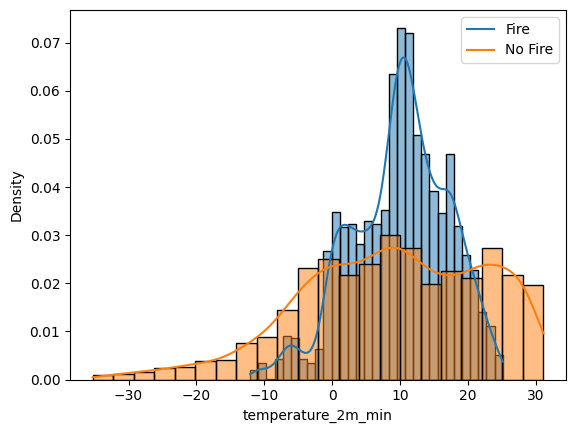

In [147]:
sns.histplot(data=positive_df, x='temperature_2m_min', stat = 'density', kde=True)
sns.histplot(data=negative_df, x='temperature_2m_min', stat = 'density', kde=True)
plt.legend(['Fire', 'No Fire'])

In [148]:
total_df = total_df[~total_df['temperature_2m_min'].isna()]
total_df = total_df.drop(columns=['latitude', 'longitude'])

In [149]:
train_set, validation_set = train_test_split(total_df, test_size = 0.1, random_state = 42)

In [150]:
display(len(train_set))
len(validation_set)

6125

681

In [151]:
total_df.head(10)

,year,month,day,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,showers_sum,snowfall_sum,wind_speed_10m_max,wind_gusts_10m_max,et0_fao_evapotranspiration,fire
0,2023,1,6,20.6,2.8,0.0,0.0,0.0,0.0,15.5,26.3,2.96,0
1,2023,1,7,17.8,2.9,0.0,0.0,0.0,0.0,10.5,14.4,2.51,0
2,2023,1,8,18.3,-1.8,0.0,0.0,0.0,0.0,10.2,12.2,2.28,0
3,2023,1,9,20.6,0.9,0.0,0.0,0.0,0.0,8.9,14.8,2.42,0
4,2023,1,10,22.2,2.8,0.0,0.0,0.0,0.0,16.2,25.2,3.15,0
5,2023,1,11,20.6,6.4,0.0,0.0,0.0,0.0,31.1,50.0,4.57,0
6,2023,1,12,18.0,1.5,0.0,0.0,0.0,0.0,16.0,34.9,3.16,0
7,2023,1,13,17.3,-2.8,0.0,0.0,0.0,0.0,11.9,18.7,2.99,0
8,2023,1,14,23.6,-1.6,0.0,0.0,0.0,0.0,29.5,43.9,2.99,0
9,2023,1,15,21.3,11.3,0.0,0.0,0.0,0.0,57.9,87.1,5.31,0


In [152]:
len(train_set[train_set['fire'].isna()])

0

In [153]:
first_model = LogisticRegression()
first_model.fit(train_set.drop(columns=['fire']), train_set['fire'])
train_acc = first_model.score(train_set.drop(columns=['fire']), train_set['fire'])
print(f'Training Accuracy: {train_acc}')
validation_acc = first_model.score(validation_set.drop(columns=['fire']), validation_set['fire'])
print(f'Validation Accuracy: {validation_acc}')

Training Accuracy: 0.888
Validation Accuracy: 0.8883994126284875


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'ROC Curve ')

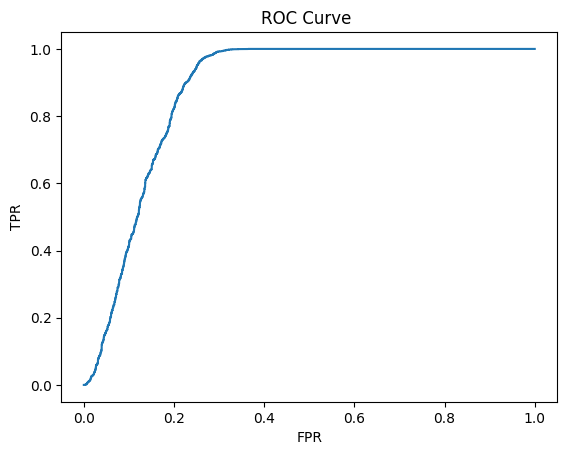

In [154]:
y_probabilities = first_model.predict_proba(train_set.drop(columns=['fire']))[:,1]
fpr, tpr, thresholds = roc_curve(train_set['fire'], y_probabilities)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve ")

In [155]:
with open('fire_pred_model_export.pkl', 'wb') as f:
    pickle.dump(first_model, f)